In [1]:
# %pip install rasterio
# %pip install geopandas
# %pip install fiona
# %pip install earthpy


import numpy as np
import numpy.ma as ma
#from matplotlib import pyplot as plt
import rasterio
import geopandas as gpd
#import rasterstats as rs
#from IPython.display import display
import pandas as pd
import os
import fiona
import rasterio.mask
#import matplotlib.pyplot as plt
import warnings
import rasterio
import rasterio.features
warnings.filterwarnings('ignore') #don't display warnings
from rasterio.mask import mask
#import earthpy.plot as ep
import cv2
import datetime
from tqdm.auto import tqdm

In [13]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
root_file = 'C:\\Users\\leoag\\Michigan State University\\MSU Dry Bean Breeding Lab - General\\UAS_Beans\\2022\\HURON_Mat'
shp_file = "22_HUR_SHP.shp"
img_dir= f"{root_file}/"'b._Orthomosaics'
shp_dir = f"{root_file}/"'c._Shapefiles'
plot_dir = f"{root_file}/"'e._ClipPlots_BN'
ground_dir = f"{root_file}/"'d._Ground_notes'

#os.chdir('/content/drive/MyDrive/temp_roi')

#plots_img = '/plots_img'

# try:
#     os.mkdir(plot_dir)
# except:
#   pass
# os.chdir(img_dir)
# # Print the current working directory
# print("Current working directory: {0}".format(os.getcwd()))
#DIR_TEST = f'{DIR_INPUT}/test'
plots = gpd.read_file(f'{shp_dir}' f'/{shp_file}')

plots_names=list(plots.columns.values)
print(plots_names)

['fid_1', 'PlotID', 'fid_2', 'PlotID_2', 'Global_ID2', 'Global_ID', 'Plot', 'ENTRY', 'REP', 'IBLK', 'Rng', 'Pas', 'Name', 'Identity1', 'Pedigree', 'Experiment', 'Origin', 'Selection', 'Descriptio', 'Year', 'Location', 'Planter', 'Harvester', 'geometry']


In [3]:
shp_file_info=fiona.open(f'{shp_dir}/'f'{shp_file}', "r") 
#first feature of the shapefile
shp_file_inf = shp_file_info.next()
print(shp_file_inf)

{'type': 'Feature', 'id': '0', 'properties': OrderedDict([('fid_1', 1.0), ('PlotID', '122'), ('fid_2', '1'), ('PlotID_2', '122'), ('Global_ID2', '2223_2031'), ('Global_ID', '22232031'), ('Plot', '2031'), ('ENTRY', '30'), ('REP', '2'), ('IBLK', '6'), ('Rng', '12'), ('Pas', '1'), ('Name', 'B21717'), ('Identity1', None), ('Pedigree', 'B16504/B17106'), ('Experiment', '2223'), ('Origin', '18B236-07-02'), ('Selection', '20T2393'), ('Descriptio', '18A0236-18L233-18-19T628-19T1291-20T2393'), ('Year', '2022'), ('Location', 'HURON'), ('Planter', '12'), ('Harvester', '360')]), 'geometry': {'type': 'Polygon', 'coordinates': [[(314787.1703460554, 4859345.088870585), (314787.9646773599, 4859345.183937819), (314788.440013524, 4859341.212281295), (314787.64568221953, 4859341.117214063), (314787.1703460554, 4859345.088870585)]]}}


In [4]:
img_list = os.listdir(img_dir)
img_list = [v for v in img_list if v.endswith('.tif')]
print(img_list)

['07_20_2022_HURON_RGB.tif', '08_18_2022_HURON_RGB.tif', '08_20_2022_HURON_RGB.tif', '08_23_2022_HURON_RGB.tif', '08_26_2022_HURON_RGB.tif', '08_30_2022_HURON_RGB.tif', '09_02_2022_HURON_RGB.tif', '09_05_2022_HURON_RGB.tif', '09_08_2022_HURON_RGB.tif', '09_13_2022_HURON_RGB.tif']


In [5]:
# Create an empty list to store the img names
img_list_names = []

for l in range(len(img_list)):
    print(l)
    img_list_names.append(str(img_list[l]))

print(img_list_names)

0
1
2
3
4
5
6
7
8
9
['07_20_2022_HURON_RGB.tif', '08_18_2022_HURON_RGB.tif', '08_20_2022_HURON_RGB.tif', '08_23_2022_HURON_RGB.tif', '08_26_2022_HURON_RGB.tif', '08_30_2022_HURON_RGB.tif', '09_02_2022_HURON_RGB.tif', '09_05_2022_HURON_RGB.tif', '09_08_2022_HURON_RGB.tif', '09_13_2022_HURON_RGB.tif']


In [6]:
plot_num_field_name = "Global_ID"
trial_name = "HUR"
planting_date = '06.08.2022'

width = 64 #256
height = 256 #64

In [7]:
# Create an empty list to store DOY from the image names
img_DOY_list = []

for l in range(len(img_list)):
    img_DOY = str(img_list[l]) 
    ts = img_DOY[0:10]
    ts = ts.replace('_', '.')
    fmt = '%m.%d.%Y'

    dt = datetime.datetime.strptime(ts, fmt)
    tt = dt.timetuple()
    tt = tt.tm_yday

    pl = planting_date
    dt2 = datetime.datetime.strptime(pl, fmt)
    tt2 = dt2.timetuple()
    tt2 = tt2.tm_yday

    tt_f = str(tt-tt2).zfill(3)

    img_DOY_list.append(tt_f)

print(img_DOY_list)

['042', '071', '073', '076', '079', '083', '086', '089', '092', '097']


In [8]:
ground_df = pd.read_csv(f"{ground_dir}/"'Ground_Notes_HUR_22_table.csv', usecols=(0,1)).astype(str)
#ground_df= ground_df.astype(str)
ground_list = []

for value in ground_df["Global_ID"]:
    ground_list.append(value)

ground_list

['22231001',
 '22231002',
 '22231003',
 '22231004',
 '22231005',
 '22231006',
 '22231012',
 '22231011',
 '22231010',
 '22231009',
 '22231008',
 '22231007',
 '22231013',
 '22231014',
 '22231015',
 '22231016',
 '22231017',
 '22231018',
 '22231024',
 '22231023',
 '22231022',
 '22231021',
 '22231020',
 '22231019',
 '22231025',
 '22231026',
 '22231027',
 '22231028',
 '22231029',
 '22231030',
 '22231036',
 '22231035',
 '22231034',
 '22231033',
 '22231032',
 '22231031',
 '22232001',
 '22232002',
 '22232003',
 '22232004',
 '22232005',
 '22232006',
 '22232012',
 '22232011',
 '22232010',
 '22232009',
 '22232008',
 '22232007',
 '22232013',
 '22232014',
 '22232015',
 '22232016',
 '22232017',
 '22232018',
 '22232024',
 '22232023',
 '22232022',
 '22232021',
 '22232020',
 '22232019',
 '22232025',
 '22232026',
 '22232027',
 '22232028',
 '22232029',
 '22232030',
 '22232036',
 '22232035',
 '22232034',
 '22232033',
 '22232032',
 '22232031',
 '22241001',
 '22241002',
 '22241003',
 '22241004',
 '22241005',

In [9]:
if len(ground_list) == len(plots):
    print('Data set has the same lenght to ground and aerial plot numbers')
    print(len(ground_list))
    print(len(plots))

else:
    print('Data set do not merge with ground and aerial plot numbers')
    print(len(ground_list))
    print(len(plots))
    

# len(ground_list)
# len(plots)

Data set has the same lenght to ground and aerial plot numbers
132
132


In [10]:
for tiffile in tqdm(img_list_names):
    print(tiffile)

    ts = tiffile[0:10]
    ts = ts.replace('_', '.')
    fmt = '%m.%d.%Y'
    dt = datetime.datetime.strptime(ts, fmt)
    tt = dt.timetuple()
    tt = tt.tm_yday
    pl = planting_date
    dt2 = datetime.datetime.strptime(pl, fmt)
    tt2 = dt2.timetuple()
    tt2 = tt2.tm_yday
    DOY = str(tt-tt2).zfill(3)
    
    noPlot_list = []
    # Plot_ID_list = []
    with fiona.open(f'{shp_dir}/'f'{shp_file}', "r") as shapefile:
    
        for feature in tqdm(shapefile):
            
            Plot_ID = feature["properties"][plot_num_field_name]
            Plot_ID = Plot_ID.replace('_', '')
            # [k for k in ground_list if Plot_ID in k]  
                      
            if Plot_ID in ground_list:
                shape = [feature["geometry"]]
                # Plot_ID_list.append(Plot_ID)
                        
            # Change the current working directory
                os.chdir(img_dir)
                
                with rasterio.open(tiffile, "r") as ras:
                    out_image, out_transform = mask(ras, shape, crop=True, nodata=0)
                    out_meta = ras.meta
                    
                    out_image = ma.masked_where(out_image == 0, out_image)
                    out_image = ma.filled(out_image.astype(float), np.nan)
                    
                # Change the current working directory
                    os.chdir(f'{plot_dir}')

                    new_img_name = trial_name + '_' + Plot_ID + '_' +  DOY + '.png'
                    
                    out_meta.update({"driver": "PNG",
                    "height": height,
                    "width": width,
                    "transform": out_transform})
                    
                    with rasterio.open(new_img_name, "w", **out_meta) as dest:
                        dest.write(out_image)
                        #print(new_img_name) 

            else:
                noPlot_list.append(Plot_ID)
                pass  

  0%|          | 0/10 [00:00<?, ?it/s]

07_20_2022_HURON_RGB.tif


  0%|          | 0/132 [00:00<?, ?it/s]

08_18_2022_HURON_RGB.tif


  0%|          | 0/132 [00:00<?, ?it/s]

08_20_2022_HURON_RGB.tif


  0%|          | 0/132 [00:00<?, ?it/s]

08_23_2022_HURON_RGB.tif


  0%|          | 0/132 [00:00<?, ?it/s]

08_26_2022_HURON_RGB.tif


  0%|          | 0/132 [00:00<?, ?it/s]

08_30_2022_HURON_RGB.tif


  0%|          | 0/132 [00:00<?, ?it/s]

09_02_2022_HURON_RGB.tif


  0%|          | 0/132 [00:00<?, ?it/s]

09_05_2022_HURON_RGB.tif


  0%|          | 0/132 [00:00<?, ?it/s]

09_08_2022_HURON_RGB.tif


  0%|          | 0/132 [00:00<?, ?it/s]

09_13_2022_HURON_RGB.tif


  0%|          | 0/132 [00:00<?, ?it/s]

In [23]:
noPlot_ID_list = pd.DataFrame(noPlot_list, columns=['Plots'])
noPlot_ID_list
#noPlot_ID_list.to_csv('C:\\Users\\leoag\\Michigan State University\\MSU Dry Bean Breeding Lab - General\\UAS_Beans\\2020\\SVREC_Mat\\f._codes\\noPlot.csv')

,Plots


In [24]:
#ep.plot_rgb(out_image, rgb=[0, 1, 2], title="Red Green Blue", stretch=True)

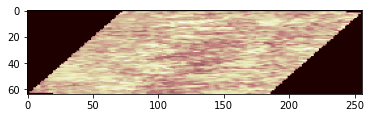

In [25]:
#plotting
from matplotlib import pyplot
with rasterio.open(new_img_name) as src:
    pyplot.imshow(src.read(1), cmap='pink')
    pyplot.show()